# LDA & QDA: дискриминантный анализ

Dataset: [armenian pubs](https://www.kaggle.com/erikhambardzumyan/pubs)

Подробнее о данных можно узнать в [предыдущей работе](https://github.com/andrgolubev/python-sandbox/blob/master/data_analysis_1.ipynb)


## Плюсы и минусы методов LDA и QDA

**Плюсы**

* Простые методы
* Показывают хорошие результаты, когда данные имеют нормальное распределение или близки к нему
* Достаточно устойчивы к выбросам 
* Можно использовать для понижения размерности

**Минусы**

* Показывают плохие результаты, когда разделяющие поверхности слишком сложные
* Работают только с числовыми признаками
* Нет естественного способа обработки пропущенных значений
* Чувствительны к масштабированию

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Предобработка данных (подробнее процесс описан в работе №1)

Используем собственную функцию для получения и обработки данных - все до момента разделения на X и Y

In [3]:
import data_retrieve as dr

In [4]:
X, data = dr.parse_and_prepare("armenian_pubs.csv", sep=",", engine="python")

#### Формируем X и Y

Для простоты дальнейшего использования в визуализации добавим Y, где классы представляются целочисленными значениями:
- 'C1' <=> 0
- 'C2' <=> 1

In [5]:
Y = None
Y_numeric = data['wts']
Y_mean = np.mean(Y_numeric)
Y = pd.Series(['C1' if val <= Y_mean else 'C2' for val in Y_numeric])
intY = pd.Series([0 if val is 'C1' else 1 for val in Y])
feature_names = X.columns
print(feature_names)
# print("Y:\n", Y[:5])
# print("Y в виде целочисленных значений:\n", intY[:5])

Index(['age', 'income', 'occupation_CEO',
       'occupation_Entrepreneur_/_Software_Engineer', 'occupation_Student',
       'occupation_Student_+_working', 'occupation_Working',
       'occupation_Working', 'occupation_army', 'freq_Several_times_a_week',
       'freq_Several_times_in_a_month', 'freq_rarely', 'prim_imp_Environment',
       'prim_imp_Menu', 'prim_imp_Music', 'prim_imp_Pricing',
       'sec_imp_Environment', 'sec_imp_Menu', 'sec_imp_Music',
       'sec_imp_Pricing', 'stratum_Capital', 'stratum_Rural', 'stratum_Urban',
       'lifestyle_Adventure/traveling/exploring', 'lifestyle_Art',
       'lifestyle_Business_sports_dance', 'lifestyle_Busy',
       'lifestyle_Nightlife', 'lifestyle_Passive', 'lifestyle_Rock_punk',
       'lifestyle_Sport', 'lifestyle_Sport_art_traveling', 'lifestyle_Student',
       'occasions_Birthdays', 'occasions_For_listening__good_music',
       'occasions_Hang_outs_with_friends', 'occasions_Never',
       'occasions_Nowere', 'occasions_Special_eve

In [6]:
print(X.shape)
print(Y.shape)

(175, 41)
(175,)


#### Разбиение на обучающую и тестовую выборки

In [7]:
from sklearn.model_selection import train_test_split
# constant random_state to have repeatability
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, random_state=7)
N_train, _ = X_train.shape
N_test, _ = X_test.shape
print(N_train, N_test)

122 53


## Линейный дискриминантный анализ

_Априорная вероятность_:

$$
{\rm Pr\,} y
$$

_Апостериорная вероятность_:

$$
{\rm Pr\,}(y \mid x) = \frac{p(x\mid y)\, {\rm Pr\,} y}{p(x)}\ 
$$

Линейный дискриминантный анализ (LDA) делает два предположения:

 - объекты каждого класса распределены по нормальному закону:

$$
p(x\mid y) = \frac{1}{\sqrt{(2\pi)^d\det\Sigma_y}}e^{-\frac{1}{2}(x-\mu_y)^{\top}\Sigma_y^{-1}(x-\mu_y)}
$$

 - матрицы ковариации $\Sigma = \Sigma_y$ одинаковы для всех классов
 
 
Нам нужно сравнить две апостериорные вероятности:

$$
{\rm Pr\,}(y \mid x) > {\rm Pr\,}(y' \mid x)
$$

Подставляя выражения для $p(x\mid y)$ и $p(x\mid y')$ и логарифмируя, приходим к неравенству:

$$
{-\frac{1}{2}(x-\mu_y)^{\top}\Sigma^{-1}(x-\mu_y)} + \ln {\rm Pr\,} y
>
{-\frac{1}{2}(x-\mu_{y'})^{\top}\Sigma^{-1}(x-\mu_{y'})} + \ln {\rm Pr\,} y'
$$

Откуда

$$
(\mu_y - \mu_{y'})^{\top} \Sigma^{-1} x >
\frac{1}{2}\mu_{y}^{\top}\Sigma^{-1}\mu_{y} - \frac{1}{2}\mu_{y'}^{\top}\Sigma^{-1}\mu_{y'}
- \ln {\rm Pr\,} y+ \ln {\rm Pr\,} y'
$$
т. е.
$$
w^{\top} x > c,
$$
где $w = (\mu_y - \mu_{y'})^{\top} \Sigma^{-1}$, а $c$ – некоторая константа.

Таким образом, 

* уравнение $w^{\top} x = c$ задает разделяющую гиперплоскость между классами $y$ и $y'$
* важна линейная комбинация признаков $x$ с коэффициентами $w$

Введем _линейную дискриминантную функцию_:
$$
\delta_y(x) = 
- \frac{1}{2}(x-\mu_y)^{\top}\Sigma^{-1}(x-\mu_y) + \frac{1}{2}x^{\top}\Sigma^{-1}x + \ln {\rm Pr}\,y
= \mu_y^{\top} \Sigma^{-1} x  - \frac{1}{2}\mu_y^{\top}\Sigma^{-1}\mu_y + \ln {\rm Pr}\,y
$$

Классификатор: объект $x$ относим к тому классу $y$, для которого $\delta_y(x)$ максимальна.

Здесь 
$$
\rho(x,x') = \sqrt{(x-x')^{\top}\Sigma^{-1}(x-x')}
$$
– это _расстояние Махаланобиса_.


### Пример данных и LDA

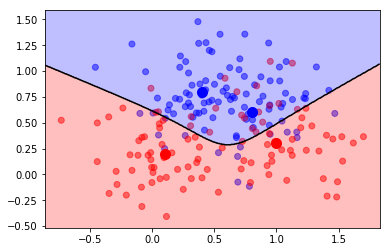

In [8]:
import mysk
Z, r = mysk.generate_points(seed = 5)
mysk.draw_points(Z, r)
mysk.draw_centers()
mysk.draw_bayes_sep_curve()

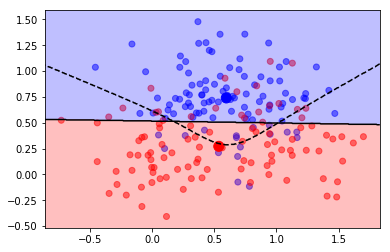

In [9]:
from sklearn import discriminant_analysis
lda_model_ex = discriminant_analysis.LinearDiscriminantAnalysis()
lda_model_ex.fit(Z, r)

mysk.draw_points(Z, r)
mysk.draw_sep_curve(lda_model_ex)
mysk.draw_bayes()
plt.scatter(lda_model_ex.means_[:, 0], lda_model_ex.means_[:, 1], color = ['b', 'r'], s = 100)

### LDA: наши данные

In [10]:
from sklearn import discriminant_analysis
lda_model = discriminant_analysis.LinearDiscriminantAnalysis()
lda_model.fit(X, Y)

/home/abay/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

#### Важно

Для наших данных LDA выдает следующее предупреждение: "Variables are collinear"

Что это означает?
Между данными векорами признаков есть корреляция:

 - LDA вычисляет обратную матрицу в ходе регрессионного анализа. В случае, если несколько признаков образуют линейную комбинацию (или почти образуют), определитель матрицы будет принимать значения близкие к 0 или 0, что означает, что нельзя посчитать обратную матрицу
 
 - Более того, тяжелее становится проинтерпретировать полученные коэффициенты. Например: если увеличение X1 влечет за собой снижение X2, но при этом X1 & X2 увеличивают выходное значение Y: каждое изменение в X1 будет "сглаживаться" изменением X2 и эффект влияния X1 на Y будет неявно уменьшен

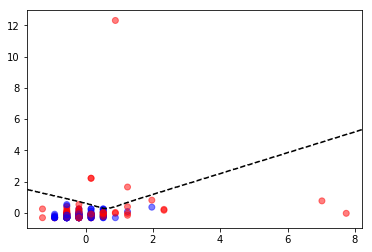

In [11]:
from numpy import array
from matplotlib.pyplot import scatter
vX = X.values # taking raw values from DataFrame for visualization
mysk.draw_points(vX, intY)
mysk.draw_bayes()

#### Замечание

Так как размерность наших признаков - 41 (число столбцов), невозможно построить график в 41-мерном пространстве

На графике видно, что классы тесно пересекаются:

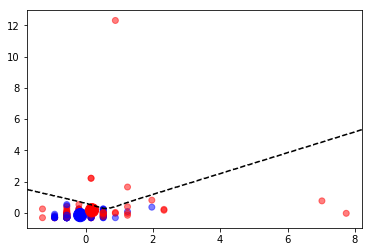

In [12]:
vX = X.values # taking raw values from DataFrame for visualization
mysk.draw_points(vX, intY)
mysk.draw_bayes()
plt.scatter(lda_model.means_[:, 0], lda_model.means_[:, 1], color = ['b', 'r'], s = Y.shape)
# _, features_number = X.shape
# dr.draw_sep_curve_and_reshape(model=lda_model, n_dims=features_number)

#### Средние значения признаков в получившейся модели для заданных классов

In [13]:
lda_model.means_

array([[-0.16002395, -0.14195012,  0.        ,  0.        ,  0.78947368,
         0.17894737,  0.02105263,  0.        ,  0.01052632,  0.11578947,
         0.38947368,  0.49473684,  0.66315789,  0.04210526,  0.23157895,
         0.06315789,  0.18947368,  0.2       ,  0.37894737,  0.23157895,
         0.78947368,  0.01052632,  0.2       ,  0.23157895,  0.15789474,
         0.        ,  0.43157895,  0.04210526,  0.01052632,  0.02105263,
         0.06315789,  0.        ,  0.        ,  0.05263158,  0.01052632,
         0.76842105,  0.02105263,  0.01052632,  0.10526316,  0.01052632,
         0.67368421],
       [ 0.19002844,  0.16856577,  0.0125    ,  0.0125    ,  0.5875    ,
         0.2875    ,  0.0875    ,  0.0125    ,  0.        ,  0.1125    ,
         0.3       ,  0.5875    ,  0.7375    ,  0.0125    ,  0.225     ,
         0.025     ,  0.1375    ,  0.2875    ,  0.375     ,  0.2       ,
         0.8       ,  0.025     ,  0.175     ,  0.2       ,  0.1125    ,
         0.0125    ,  0.4625 

#### Подсчет ошибок

In [14]:
err_train = np.mean(Y != lda_model.predict(X))
err_test = np.mean(Y_test != lda_model.predict(X_test))
print(err_train, err_test)

0.331428571429 0.452830188679


#### Априорные вероятности

Так как Y - бинарный: "C1" или "C2", то вероятностей 2:

${\rm Pr\,}(y="C1")$ и ${\rm Pr\,}(y="C2")$


In [15]:
print(lda_model.priors_)

[ 0.54285714  0.45714286]


#### Коэффициенты

Получившиеся коэффициенты: $w^{\top}$

Например, из уравнения: $w^{\top} x = c$

Их количество должно быть равно количеству признаков

In [16]:
print(lda_model.coef_)
_, features_number = X.shape
print("LDA coeffs. size: ", len(lda_model.coef_[0]))
print("Features size: ", features_number)

[[ 0.27740696  0.62680609  1.40307308 -6.30391299 -0.28089491  0.24307411
   0.74922389  1.96613481 -0.85873413  0.04206988 -0.3644058   0.31548803
   0.02775051 -1.02188312  0.2231268  -0.39344358 -0.52747661  0.54431989
  -0.02070719 -0.12261919  0.05564178 -1.17645954  0.06980945  0.0745379
   0.55170913  1.40307308  0.5361081   0.33274216 -1.48943846  1.46187584
   0.20582653  3.88899053  2.67798928  3.78416755  0.75886872  2.81468847
  -0.11573112  0.58795208  2.80006885  1.00112114 -0.88747189]]
LDA coeffs. size:  41
Features size:  41


## Квадратичный дискриминантный анализ

### Пример данных и QDA

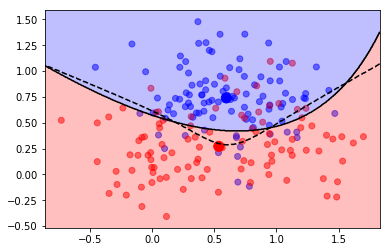

In [17]:
qda_model_ex = discriminant_analysis.QuadraticDiscriminantAnalysis()
qda_model_ex.fit(Z, r)

mysk.draw_points(Z, r)
mysk.draw_sep_curve(qda_model_ex)
mysk.draw_bayes()
plt.scatter(qda_model_ex.means_[:, 0], qda_model_ex.means_[:, 1], color = ['b', 'r'], s = 100)

### QDA: наши данные

In [18]:
qda_model = discriminant_analysis.QuadraticDiscriminantAnalysis()
qda_model.fit(X, Y)

/home/abay/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

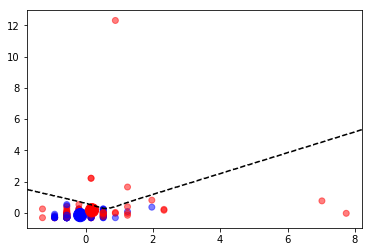

In [19]:
mysk.draw_points(vX, intY)
mysk.draw_bayes()
plt.scatter(qda_model.means_[:, 0], qda_model.means_[:, 1], color = ['b', 'r'], s = Y.shape)

#### Ошибки

In [20]:
err_train = np.mean(Y != lda_model.predict(X))
err_test = np.mean(Y_test != lda_model.predict(X_test))
print(err_train, err_test)

0.331428571429 0.452830188679


## LDA для понижения размерности

### Пример данных

In [21]:
from sklearn import datasets
iris = datasets.load_iris()

X_iris = iris.data
y_iris = iris.target
names = iris.target_names

lda_model = discriminant_analysis.LinearDiscriminantAnalysis(n_components = 2)
lda_model.fit(X_iris, y_iris)
X_iris_lda = lda_model.transform(X_iris) # projected data

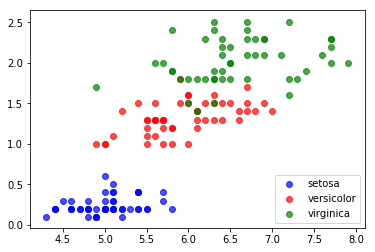

In [22]:
plt.scatter(X_iris[y_iris == 0, 0], X_iris[y_iris == 0, 3], color = 'b', label = names[0], alpha = 0.7)
plt.scatter(X_iris[y_iris == 1, 0], X_iris[y_iris == 1, 3], color = 'r', label = names[1], alpha = 0.7)
plt.scatter(X_iris[y_iris == 2, 0], X_iris[y_iris == 2, 3], color = 'g', label = names[2], alpha = 0.7)

plt.legend(loc = 4)
pass

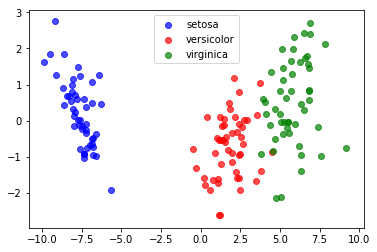

In [23]:
plt.scatter(X_iris_lda[y_iris == 0, 0], X_iris_lda[y_iris == 0, 1], color = 'b', label = names[0], alpha = 0.7)
plt.scatter(X_iris_lda[y_iris == 1, 0], X_iris_lda[y_iris == 1, 1], color = 'r', label = names[1], alpha = 0.7)
plt.scatter(X_iris_lda[y_iris == 2, 0], X_iris_lda[y_iris == 2, 1], color = 'g', label = names[2], alpha = 0.7)

plt.legend(loc = 9)
pass

### Наши данные

In [24]:
data_names = ["C1", "C2"]

lda_model2 = discriminant_analysis.LinearDiscriminantAnalysis(n_components = 2)
lda_model2.fit(X, Y)
X_projected = lda_model2.transform(X)

/home/abay/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [25]:
print("X.shape: ", X.shape)
print("X_projected.shape: ", X_projected.shape)
print("Y.shape: ", Y.shape)

X.shape:  (175, 41)
X_projected.shape:  (175, 1)
Y.shape:  (175,)


На графике ниже видно, что данные практически не отличимы

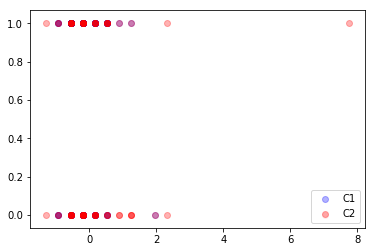

In [26]:
X_arr = X.values
plt.scatter(X_arr[Y == 'C1', 0], X_arr[Y == 'C1', 40], color = 'b', label = data_names[0], alpha = 0.3)
plt.scatter(X_arr[Y == 'C2', 0], X_arr[Y == 'C2', 40], color = 'r', label = data_names[1], alpha = 0.3)

plt.legend(loc = 4)
pass

После применения проекции (LDA.transform(...)) стало возможным различить (хотя бы как-то) множество признаков:

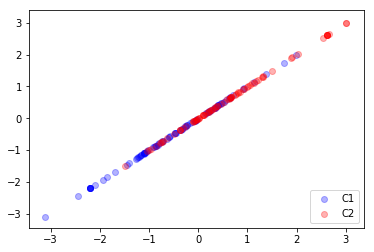

In [27]:
plt.scatter(X_projected[Y == 'C1', 0], X_projected[Y == 'C1', 0], color = 'b', label = data_names[0], alpha = 0.3)
plt.scatter(X_projected[Y == 'C2', 0], X_projected[Y == 'C2', 0], color = 'r', label = data_names[1], alpha = 0.3)

plt.legend(loc = 4)
pass